In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import math
import random
# import cv2 as cv
%matplotlib inline

# Meteo Webcam Analysis

The goal of this project is to analyze webcam capture images from [meteo.physic.ut.ee](https://meteo.physic.ut.ee/) and practice applying different analysis methods on the data. 
All images used here are downloaded from the [archive](https://meteo.physic.ut.ee/webcam/uus/archive/). Thank you to the Laboratory of Environmental Physics in University of Tartu (Institute of Physics) for keeping this archive open and free to use.

Ideas:
- Skies only (top 310 pixels).
- Cars in the parking lot.
- Weather, duration of days, light.
- People.
- Lights in the buildings.

Video clips of the archived footage can be found in the same location as the images, or in the form of a timelapse: [2019](https://youtu.be/q_ZRND_3uQY) and [2020](https://youtu.be/9cNdEs1fOOQ).

## Skies

Create a dataset of the sky only.

In [3]:
def create_skies(resize_n, path_from, path_to):
    for month in os.listdir(path_from):
        for hour in os.listdir(path_from + month):
            img_arr = np.array(Image.open(path_from + month + '/' + hour))
            
            # Trim, keep the sky
            img_trimmed = img_arr[:310,:]
            
            # Resize by n (given as arg)
            img_resized = img_trimmed[::resize_n, ::resize_n]
            
            # Save image
            path = path_to + hour[:13] + '.jpg'
            plt.imsave(path, img_resized)
            

# The raw data folders included .jpg images from the webcam archive
for year in ['data/raw/2020/', 'data/raw/2019/']:
    create_skies(5, year, 'data/256/')
    create_skies(2, year, 'data/640/')

In [2]:
folder = 'data/256/' # Skies downscaled 5x
num_of_imgs = len(os.listdir(folder)[:2500])
width = 256
height = 62

data = np.ndarray(shape=(num_of_imgs, height, width, 3), dtype=np.float32)
full_labels = np.ndarray(shape=(num_of_imgs), dtype=object)
labels = np.ndarray(shape=(num_of_imgs), dtype=np.uint8)

data.shape, labels.shape

((2500, 62, 256, 3), (2500,))

In [3]:
# Load the images from disk (check RAM!)
for i,file in enumerate(os.listdir(folder)[:2500]): 
    img = Image.open(folder + file)
    data[i] = img
    
    img_normal = data[i].astype(np.float32)
    img_normal /= 255.0
    data[i] = img_normal
    # Todo normalize further
    
    date = file[5:-4].replace('-','').replace('T','')
    full_labels[i] = date
    labels[i] = int(date[4:])

1. 10
2. 3
3. 12


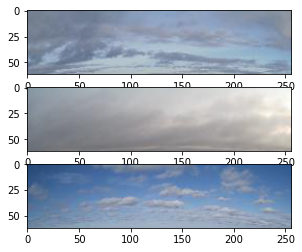

In [4]:
# Image preview
nums = [random.randint(0,len(data)) for i in range(3)]

_, ax = plt.subplots(len(nums), 1)
for i,num in enumerate(nums):
    print(f'{i+1}. {labels[num]}')
    ax[i].imshow(data[num])
    
plt.show()

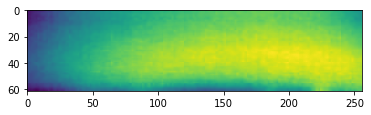

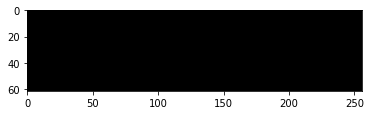

In [5]:
# Average of colors
plt.imshow(np.mean(data, axis=(0,3)))
plt.show()
plt.imshow(np.average(data, axis=0).astype(np.uint8))
plt.show()

In [22]:
# Average pixel values for each day
sky = pd.DataFrame({"pixel_avg": [np.mean(data[i], axis=(0,1,2)) for i in range(len(data))], 
                   "month": [int(lbl[:2]) for lbl in full_labels], 
                   "day": [int(lbl[2:4]) for lbl in full_labels],
                   "hour": labels})
sky

,pixel_avg,month,day,hour
0,0.700446,7,13,1
1,0.570148,4,5,7
2,0.615767,1,29,7
3,0.195738,11,20,19
4,0.650243,8,25,2
...,...,...,...,...
2495,0.669740,7,9,9
2496,0.015873,2,24,23
2497,0.663236,6,9,14
2498,0.607087,5,10,15


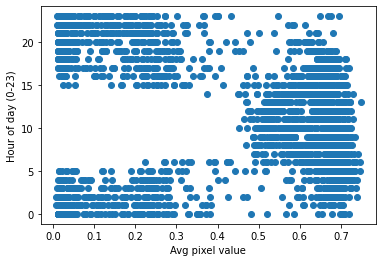

In [8]:
plt.plot(sky.pixel_avg, sky.hour, 'o')
plt.xlabel('Avg pixel value')
plt.ylabel('Hour of day (0-23)')
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import  accuracy_score, max_error, mean_squared_error


# Data split
X = sky.drop('pixel_avg', axis=1)
y = sky.pixel_avg
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=33)

# The models
model = KNeighborsRegressor(n_neighbors=11)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ...

print("X values:", X_test[1])
print("Real y:", y_test[1])
print("Predicted y:", y_pred[1])
print("RMSE: %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))

X values: [ 7 24 16]
Real y: 0.6520577073097229
Predicted y: 0.6280460466038097
RMSE: 0.1384


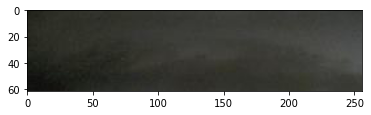

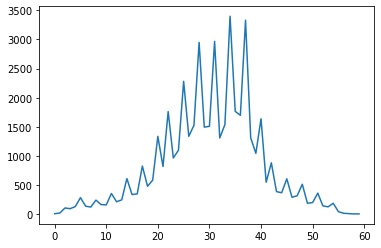

In [10]:
# Histogram of color values
num = 1333
hist, _ = np.histogram(data[num], bins=60)
plt.imshow(data[num])
plt.show()
plt.plot(hist)
plt.show()

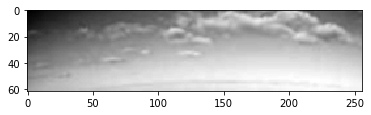

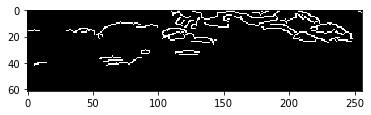

In [61]:
# Edge detection for clouds
gray = cv.cvtColor(data[num], cv.COLOR_BGR2GRAY)
blur = cv.GaussianBlur(gray,(3,3),0)
blur = (blur*255).astype(np.uint8)

plt.imshow(blur, cmap = 'gray')
plt.show()

edges = cv.Canny(blur, 20, 50)
plt.imshow(edges, cmap = 'gray')
plt.show()

In [12]:
# Weather Archive data for 2019-2020
ilm = pd.read_csv('data/ilm.txt', converters = {'Aeg': str}, low_memory=False)
ilm

,Aeg,Temperatuur,Niiskus,Õhurõhk,Tuule kiirus,Tuule suund,Sademed,Kiirgusvoog
0,2019-01-01 00:00:00,-1.23736363636,88.1365909091,1012.7914,6.09011515383854,227.484862068148,0,4.53461263033
1,2019-01-01 00:05:00,-1.21808558559,87.8435135135,1012.53586667,6.11330606001959,227.506330835414,0,4.5032680208
2,2019-01-01 00:10:00,-1.21263038549,87.7411337868,1012.2089,6.48321471404227,225.668215788586,0,4.43506124812
3,2019-01-01 00:15:00,-1.19359550562,87.2522247191,1011.9369,7.56929300146413,224.767034133404,0,4.65262881253
4,2019-01-01 00:20:00,-1.17162528217,87.0139051919,1011.64863333,7.57756146304209,212.785738093244,0,4.6012228156
...,...,...,...,...,...,...,...,...
213404,2020-12-30 23:35:00,1.35175182482,95.4888807786,1007.8573,2.58637133422684,132.379030759991,0,0.0759026599588
213405,2020-12-30 23:40:00,1.33815085158,95.5119951338,1007.88506667,2.50391640416124,135.617831524895,0,0
213406,2020-12-30 23:45:00,1.33600484262,95.4373365617,1007.78196667,2.14926338246903,129.967416236214,0,0.11824856953
213407,2020-12-30 23:50:00,1.3116626506,95.383373494,1007.71786667,2.56973670079035,125.003436380756,0,0.0889317985478


In [13]:
# Convert data to float
for col in ilm.columns:
    if col != 'Aeg':
        ilm[col] = pd.to_numeric(ilm[col], errors='coerce')

ilm = ilm.dropna()
ilm.describe()

,Temperatuur,Niiskus,Õhurõhk,Tuule kiirus,Tuule suund,Sademed,Kiirgusvoog
count,206135.000000,206135.000000,206135.000000,206135.000000,206135.000000,206135.000000,206135.000000
mean,7.940112,76.959687,1011.478380,3.546619,201.742721,0.004955,119.533188
std,8.180428,18.802441,10.444540,1.725696,89.969486,0.046039,202.388781
min,-19.621798,16.408545,970.087600,0.018976,0.004767,0.000000,0.000000
25%,1.691657,65.262441,1005.573850,2.280485,128.425260,0.000000,1.654726
50%,6.729571,82.792365,1012.246333,3.277881,227.491737,0.000000,6.205900
75%,14.375368,91.769857,1018.413983,4.563841,273.807893,0.000000,148.266281
max,32.371133,100.065838,1041.645767,15.497177,360.000000,4.576000,1132.409778


In [24]:
sky = sky.sort_values(by=['month', 'day', 'hour'])
sky = sky.reset_index(drop=True)
sky

,pixel_avg,month,day,hour
0,0.023285,1,1,0
1,0.016157,1,1,4
2,0.015273,1,1,5
3,0.223322,1,1,6
4,0.681331,1,1,7
...,...,...,...,...
2495,0.553817,12,31,10
2496,0.560638,12,31,14
2497,0.320621,12,31,15
2498,0.340640,12,31,16
